Probably the first script to use.
You will need series of files with lists of differentially expressed genes.
This script will compile a unified list of all genes from all lists and give a citation frequency of each gene. By our definition (used through the paper) all genes with frequency above 3 comprise the Aging Signature list. 

Make nesessary preparations for the analysis of the aging data. You will need:
1. Recent python 3+ version
2. Installed jupyter notebook (via anaconda or standalone). Note, you can use Colab on Google Drive (I use it to update these scripts). If you are in colab, you can access source files directly from the GitHub, no need to download (at least it works for me).
3. Source files. The files used in the paper can be found next to this script. They are all uniformly organised as tab-separated text files. Each of them contains two lines of headings. Gene names are in the second column, fold changes are in the third column. All other data are not used in current scripts.
Note that python counts from 0, therefore the second column is *col[1]*, and the 3rd column is *col[2]* 

Import necessary packages

In [33]:
import matplotlib.pyplot as plt, numpy as np, math, scipy.stats as stats 
import pandas as pd 
from urllib.request import urlopen
print("imported")

imported


This version reads source files from my GitHub. However, I did not make a modification for saving results in the GitHub. Those parts of the script are still in the offline style. <br>
List all files you will import for analysis: "sets"
Make shortlists from all signature files: "setnames"
The block below is for META-files, meaning they are derived from the supplementary files provided by authors. 

In [2]:
#meta data from meta directory
#for online files in GitHub
url="https://github.com/LeonidBystrykh/data-for-manuscript/blob/meta/"
#for offline use your directory 
mdir="/Users/leonid/Documents/Publications_Presentations/2020/AgingSign/data/meta/"


In [4]:
#if it was meta set
import os
mdir="/Users/leonid/Documents/Publications_Presentations/2020/AgingSign/data/meta/"
filenames = next(os.walk(mdir))[2] 
sets=[x for x in filenames if ".txt" in x]
print(sets)
setnames=[x[:-4] for x in sets]

['Wahlestedt_2013.txt', 'Beerman_2013.txt', 'Rossi_2005.txt', 'Kowalczyk_2015.txt', 'Sun_2014.txt', 'Flach_2014.txt', 'Kirschner_2017.txt', 'Noda_2009.txt', 'Grover_2016.txt', 'Chambers_2007.txt', 'Quere_2014.txt']


The block below is for reanalysed files.  The structure and variable names are the same as above, therefore you can use either of those block, but not both at the same time (this is not recommended, because some of the files will be partial duplicates of itself and cause statistical bias).

In [34]:
#reanalysed files from rean directory
mdir="/Users/leonid/Documents/Publications_Presentations/2020/AgingSign/data/rean/"
filenames = next(os.walk(mdir))[2] 
sets=[x for x in filenames if ".csv" in x]
print(sets)
#make sure you do not use files you do not need
sets=['Chambers_GSE6503.csv', 'Mann_GSE1004426.csv', 'Kowalczyk_GSE59114.csv', 'Norddahl_GSE27686.csv', 
      'Maryanovich_GSE109546.csv', 'Wahlestedt_GSE44923.csv', 'Flach_GSE48893.csv', 'Lazare_GSE128050.csv', 
      'Bersenev_GSE39553.csv', 'Grover_GSE70657.csv', 'Sun_GSE47817.csv', 'Kirschner_GSE87631.csv']
setnames=[x[:-4] for x in sets]

['Chambers_GSE6503.csv', 'Mann_GSE1004426.csv', 'AS_rean_table.csv', 'Kowalczyk_GSE59114.csv', 'Norddahl_GSE27686.csv', 'Maryanovich_GSE109546.csv', 'Wahlestedt_GSE44923.csv', 'Flach_GSE48893.csv', 'Lazare_GSE128050.csv', '.~lock.Bersenev_GSE39553.csv#', 'Bersenev_GSE39553.csv', 'Grover_GSE70657.csv', 'Sun_GSE47817.csv', 'Kirschner_GSE87631.csv']


open every file and collect all names of genes
names is set of sets, 
fcs are fold changes per gene
allg (all genes) and 
allf (all found times) are united set with frequencies

In [48]:
"""here I have to make lists of gene names per set, fold changes per gene per set,
list of all genes in all sets and frequencies of genes in all set"""
names,fcs,allg,allf, allgenes=[],[],[],[],[]
print("file\t\t\tlen\tpos\tneg")
for fl in sets:
#    file = urlopen(url+ fl +"?raw=True") #for online files
    file=mdir+fl #for offline files
    mytable=pd.read_csv(file,index_col=0, skiprows=0, header=1, sep="\t")
    na,fc=mytable[mytable.columns[0]],mytable[mytable.columns[1]] #list of genes (na) and frequencies (fc) per set
    names.append(list(na))
    fcs.append(list(fc))
    allgenes+=list(na)
    print(fl, str(len(mytable)), 
          str(len([x for x in fc if float(x)>0])),
          str(len([x for x in fc if float(x)<0])) , sep="\t")
for name in set(allgenes):
  allg.append(name)
  allf.append(allgenes.count(name))

file			len	pos	neg
Chambers_GSE6503.csv	2059	987	1072
Mann_GSE1004426.csv	68	61	7
Kowalczyk_GSE59114.csv	272	107	165
Norddahl_GSE27686.csv	775	549	226
Maryanovich_GSE109546.csv	1100	549	551
Wahlestedt_GSE44923.csv	395	306	89
Flach_GSE48893.csv	181	54	127
Lazare_GSE128050.csv	83	67	16
Bersenev_GSE39553.csv	330	234	96
Grover_GSE70657.csv	99	65	34
Sun_GSE47817.csv	2622	1483	1139
Kirschner_GSE87631.csv	30	21	9


In [36]:
#This part works with a nasty glitch. On a Github it prints all lists in full length
#Therefore better skip it or print something short instead
print("Names", len(names))
print("FCs", len(fcs))
print("All genes", len(allg))
print("All frequencies", len(allf))
print("Checked")

Names 12
FCs 12
All genes 5455
All frequencies 5455
Checked


In [37]:
#all genes list needs some cleaning, remove nameless 'nan' items and multiple names 
new_g, new_fc=[],[]
for i in range(len(allg)):
 # print(allg[i])
  if str('///') in str(allg[i]): 
    pass
  elif str(allg[i])=='nan':
    pass
  else:
    new_g.append(allg[i])
    new_fc.append(allf[i])
print("filtered genes", len(new_g))
print("filtered_freqs", len(new_fc))
allg,allf=new_g, new_fc

filtered genes 5343
filtered_freqs 5343


All requred data are collected.
We can check every set name, lenth of every gene set, print first 10 names from each set
We also check for possible damage in gene names.
Some tables, when open/saved in excel loose original gene names, which became a dates, like "Mar-2", or "Sep-5". so we collect those if they are (or any other characters)

In [38]:
print("summary")
for i in range(len(sets)):
        print(sets[i],len(names[i]),names[i][:5],"...")
        mar=[x for x in names[i] if "Sep-" in str(x)]
        if len(mar)>0:
            print("found Mar", sets[i], mar)
    

summary
Chambers_GSE6503.csv 2059 ['Vopp1', 'Smc6', 'Prkrip1', 'Acvr2b', 'Smek2'] ...
Mann_GSE1004426.csv 68 ['Nupr1', 'Gda', 'Selp', 'Sult1a1', 'Clec1a'] ...
Kowalczyk_GSE59114.csv 272 ['uc012hdk.1', 'Clca1', 'Mt1', 'Nupr1', 'Selp'] ...
Norddahl_GSE27686.csv 775 ['Gpr183', 'Ctse', 'Eya4', 'Tc2n', 'Wwtr1'] ...
Maryanovich_GSE109546.csv 1100 ['Gnai3', 'Tbx4', 'Xpo6', 'Ccnd2', 'Mid2'] ...
Wahlestedt_GSE44923.csv 395 ['Sbspon', 'Osmr', 'Tc2n', 'Wwtr1', 'Pgr'] ...
Flach_GSE48893.csv 181 ['Gpr183', 'Socs2', 'Tdrd9', 'Ebi3', 'Fyb'] ...
Lazare_GSE128050.csv 83 ['Uhrf1', 'Ramp2', 'Vwf', 'Gria3', 'Cd34'] ...
Bersenev_GSE39553.csv 330 ['Mt2', 'Plscr2', 'Selp', 'Clca3a1', 'Bmpr1a'] ...
Grover_GSE70657.csv 99 ['Erdr1', 'Xist', 'Eif2s3y', 'Mt1', 'Nupr1'] ...
Sun_GSE47817.csv 2622 ['Gnai3', 'Slfn4', 'Drp2', 'Mid2', 'Tpd52l1'] ...
Kirschner_GSE87631.csv 30 ['Fosb', 'Fos', 'Erdr1', 'Mt1', 'Nfkbid'] ...


Here is the block to collect all frequencies for all genes. It is needed to calculate average fold change for each gene, which comes next after this block.

In [39]:
allfcs=[] #all fold changes
for gene in allg:
    folds=[]
    for i in range(len(names)):
        for j in range(len(names[i])):
            if gene==names[i][j]:
                folds.append(fcs[i][j])
    allfcs.append(folds)
print("ready to make the AgingList file")

ready to make the AgingList file


Now we can save the data in the Aging List file.
Choose one of two blocks below, depending on what set of data you have used. We will save average of all fold changes.
We can also save all fold changes as a list in a separate column, if we want. To do so just add allfcs[i] as separate column in f_out.writelines() line

block below is for META data, and the list will be saved into "rean_gene_fcs_META.txt".

In [ ]:
f_out=open("Aging_List_META.txt","w")
f_out.writelines("Gene\tFreq_group\tLog2FC\n")

for i in range(len(allg)):
   # print(allg[i],allf[i], allfcs[i])
    f_out.writelines(allg[i]+"\t"+str(allf[i])+"\t"+str(sum(allfcs[i])/len(allfcs[i]))+"\n")
f_out.close()

block below is for reanalysed data, and the list will be saved into "rean_gene_fcs_REAN.txt".

In [ ]:
f_out=open("Aging_List_REAN.txt","w")
f_out.writelines("Gene\tFreq_group\tLog2FC\n")

for i in range(len(allg)):
   # print(allg[i],allf[i], allfcs[i])
    f_out.writelines(allg[i]+"\t"+str(allf[i])+"\t"+str(sum(allfcs[i])/len(allfcs[i]))+"\n")
f_out.close()
print("AgingList saved")

AgingList saved


In principle, the Aging List is the most important part of the scipt. You can stop here and proceed with the next script for further study and use of the aging signature. 
Below are some additional files which you can use if you want it.
Here is a cross-comparison of all files used for the list.

In [40]:
print("table of intersects\t set_size\t Intersects_tab\t all_intersected\t nr_intersected\t fraction_intersected")
s,v,u,dists=[],[],[],[] # u for unique genes
for i in range(len(names)):
    val,uni=[],[]
    "define pos, neg"
    for j in range(len(names)):
        ovl=[x for x in names[i] if x in names[j]]
        if i!=j:
            val.append(len(ovl))
            for o in ovl:
                if o not in uni:
                    uni.append(o)
        else:
            self=len(ovl) #dirty trick for own size
            val.append(0)
    u.append(uni)
    s.append(self)
    dists.append(val)
    v.append(len(uni)) #length unique list
    print(sets[i],self,val,sum(val),len(uni), len(uni)/self, sep="\t")
    

table of intersects	 set_size	 Intersects_tab	 all_intersected	 nr_intersected	 fraction_intersected
Chambers_GSE6503.csv	2059	[0, 18, 63, 165, 169, 97, 58, 21, 84, 38, 208, 10]	931	353	0.1714424477901894
Mann_GSE1004426.csv	68	[13, 0, 32, 37, 33, 30, 9, 17, 23, 18, 34, 5]	251	55	0.8088235294117647
Kowalczyk_GSE59114.csv	272	[46, 32, 0, 56, 51, 38, 18, 15, 40, 28, 70, 9]	403	131	0.48161764705882354
Norddahl_GSE27686.csv	775	[182, 63, 77, 0, 238, 287, 84, 69, 179, 61, 348, 15]	1603	442	0.5703225806451613
Maryanovich_GSE109546.csv	1100	[140, 33, 51, 179, 0, 139, 37, 56, 140, 25, 503, 8]	1311	619	0.5627272727272727
Wahlestedt_GSE44923.csv	395	[107, 48, 52, 282, 177, 0, 60, 62, 165, 43, 209, 14]	1219	271	0.6860759493670886
Flach_GSE48893.csv	181	[32, 9, 18, 42, 37, 29, 0, 13, 33, 11, 39, 5]	268	89	0.49171270718232046
Lazare_GSE128050.csv	83	[17, 17, 15, 46, 56, 41, 13, 0, 45, 14, 74, 5]	343	76	0.9156626506024096
Bersenev_GSE39553.csv	330	[49, 23, 40, 123, 140, 112, 31, 45, 0, 31, 176, 12]	

The table above can be presented as a heatmap below

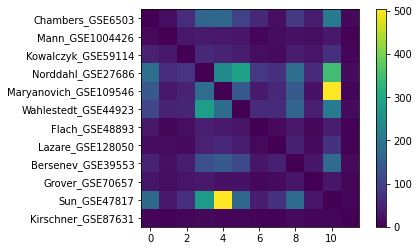

In [41]:
#heatmap figure for similarities between gene sets
plt.imshow(dists)
plt.yticks(range(len(setnames)),setnames)
plt.colorbar();
#plt.show()


In [24]:
#check variables for the block below
print(len(names))
print(len(names[0]))
print(names[0][0])
#print(len(allg), allg[:10])
#print(len(allf), allf[:10])

12
330
Mt2


The block below seems to have a trouble in colab, more power is needed.
At the end some summary table for each file used for the Aging List

In [43]:
print("Colab cannot handle this part. Do it offline")
print("make groups of genes by their frequencies of occurrence")
print("per set")
print("set\ttotal\t>3\t relative") #\t p_hypergeometric
rel_dists=[]
for val in range(len(sets)):
    total,sig=len(names[val]),0
    for name in names[val]:
    #    print("name", name)
        if name in allg:
            score=allf[allg.index(name)]
   #     print(name, score)
            if int(score)>3:
                sig+=1
    rel_dists.append(float(sig)/float(total))
    print(sets[val], total, sig, float(sig)/float(total), sep="\t") #myp,

Colab cannot handle this part. Do it offline
make groups of genes by their frequencies of occurrence
per set
set	total	>3	 relative
Chambers_GSE6503.csv	2059	161	0.07819329771733852
Mann_GSE1004426.csv	68	41	0.6029411764705882
Kowalczyk_GSE59114.csv	272	64	0.23529411764705882
Norddahl_GSE27686.csv	775	303	0.3909677419354839
Maryanovich_GSE109546.csv	1100	184	0.16727272727272727
Wahlestedt_GSE44923.csv	395	225	0.569620253164557
Flach_GSE48893.csv	181	51	0.281767955801105
Lazare_GSE128050.csv	83	55	0.6626506024096386
Bersenev_GSE39553.csv	330	137	0.41515151515151516
Grover_GSE70657.csv	99	39	0.3939393939393939
Sun_GSE47817.csv	2622	205	0.07818459191456903
Kirschner_GSE87631.csv	30	13	0.43333333333333335


We can draw those results in different ways. Here is the script to make a "dart-plot"
of data sets similarity degree to the aging signature. To do so we need to use Set names, their sizes, and relative distances to the Aging Signature. Here we use the last column from the table above, namely relative values (number of genes found in signature divided by total number of genes.

In [44]:
sizes=[len(x) for x in names]
for i in range(len(sizes)):
    print(sets[i], sizes[i],
          #rel_dists[i], #this part is calculated i
          sep="\t")

Chambers_GSE6503.csv	2059
Mann_GSE1004426.csv	68
Kowalczyk_GSE59114.csv	272
Norddahl_GSE27686.csv	775
Maryanovich_GSE109546.csv	1100
Wahlestedt_GSE44923.csv	395
Flach_GSE48893.csv	181
Lazare_GSE128050.csv	83
Bersenev_GSE39553.csv	330
Grover_GSE70657.csv	99
Sun_GSE47817.csv	2622
Kirschner_GSE87631.csv	30


if sets, sizes and rel_dists are OK, we can do a little geometric exersise and draw the "dart-Plot". First, we make some scale adjustments to the data. It is needed to adjust it to the figure size

In [45]:
u,v=[],[]
size=[float(x)/10 for x in sizes]
dist=[(1-float(x))*10 for x in rel_dists]

next we use our geometric knowledge and find positions for the nodes we will draw

In [46]:
setlength=len(dist)
for i in range(setlength):
    u.append(round(math.sin(i*2*np.pi/setlength)*float(dist[i]),4))
    v.append(round(math.cos(i*2*np.pi/setlength)*float(dist[i]),4))
print(u)
print(v)

[0.0, 1.9853, 6.6225, 6.0903, 7.2116, 2.1519, 0.0, -1.6867, -5.0649, -6.0606, -7.9832, -2.8333]
[9.2181, 3.4386, 3.8235, 0.0, -4.1636, -3.7272, -7.1823, -2.9215, -2.9242, -0.0, 4.6091, 4.9075]


Now we can draw our nodes and edges. Note that colors and line thickness can be changed too

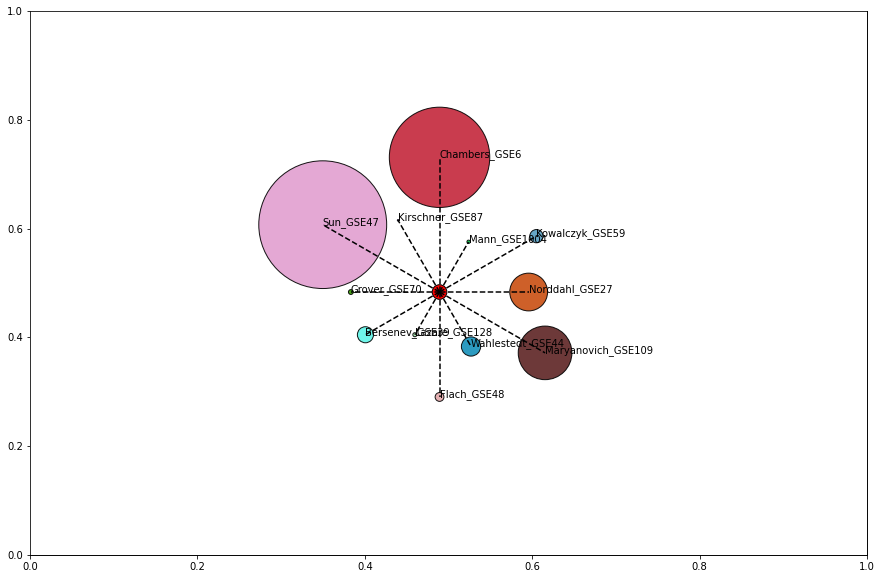

In [47]:
from matplotlib.patches import Ellipse
import numpy.random as rnd

#my struggles to control the figure size
#plt.figure(figsize=(15,5))
fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(15,10))
#fig = plt.figure(0)
ax = fig.add_subplot(111)#, aspect='equal')
"draw ellipses"
for i in range(len(u)):
    ells = [Ellipse(xy=(u[i],v[i]), width=size[i]/30, height=size[i]/30,
                    facecolor=rnd.rand(3),alpha=0.9, edgecolor="black")]
    for e in ells:
        ax.add_artist(e)
"add lines"
for i in range(len(v)):
    plt.plot([0,u[i]],[0,v[i]],"--", color="black")
    plt.text(u[i],v[i],sets[i][:-7])
"add central hub"
ell=Ellipse(xy=(0,0), width=1, height=1,facecolor="red",alpha=1, edgecolor="black")
ax.add_artist(ell)

ax.set_xlim(min(u+v)-20, max(u+v)+20)
ax.set_ylim(min(u+v)-10, max(u+v)+10)

#ax.set_aspect(0.9) #shape of the graph rectangle
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)

Depending on your browser you might see the same figures differently.  Details can be found in stackoverflow: https://stackoverflow.com/questions/19410042/how-to-make-ipython-notebook-matplotlib-plot-inline
Further adjustments are probably better to make in regular IDEs, like Spyder3 or PyCharm CE. 
